In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm
from IPython.display import display, clear_output
from time import sleep

In [47]:
filename1 = "/home/sacchin/Desktop/dnt/RL Tutorials/Grid Worlds/0.1grid_world.pkl"

In [48]:
class GeneralGridWorld:
    def __init__(self, filename, size=100):
        self.size = size
        self.filename = filename
        self.reset()

    def reset(self):
        self.agent_pos = (0, 0)
        self.goal = (50, 50)
        self.obstacles = self.generate_obstacles()
        self.validate_positions()
        self.state = np.zeros((self.size, self.size))
        return self.get_state()

    def generate_obstacles(self):
        obstacles = set()
        with open(self.filename, 'rb') as file:
            temp_gw = pickle.load(file)

        for i, value1 in enumerate(temp_gw):
            for j, value2 in enumerate(value1):
                if value2==1:
                    obstacles.add((i,j))
        return obstacles

    def validate_positions(self):
        if self.agent_pos in self.obstacles or self.goal in self.obstacles:
            raise ValueError("Agent's initial position or goal cannot be on an obstacle.")

    def get_state(self):
        # Create a state representation, for example, a flattened grid
        self.state = np.zeros((self.size, self.size))
        self.state[self.agent_pos] = 1  # Represent the agent
        self.state[self.goal] = 2  # Represent the goal
        for obs in self.obstacles:
            self.state[obs] = -1  # Represent obstacles
        return self.state.flatten()

    def step(self, action):
        # Define actions: 0=Up, 1=Down, 2=Left, 3=Right
        next_pos = list(self.agent_pos)
        if action == 0 and self.agent_pos[0] > 0:
            next_pos[0] -= 1
        elif action == 1 and self.agent_pos[0] < self.size - 1:
            next_pos[0] += 1
        elif action == 2 and self.agent_pos[1] > 0:
            next_pos[1] -= 1
        elif action == 3 and self.agent_pos[1] < self.size - 1:
            next_pos[1] += 1
        next_pos = tuple(next_pos)

        reward = 5  # Default reward
        done = False
        if next_pos in self.obstacles:
            reward = -10  # Penalty for hitting an obstacle
        elif next_pos == self.goal:
            reward = 10000  # Reward for reaching the goal
            done = True

        self.agent_pos = next_pos
        return self.get_state(), reward, done

    def render(self):
        grid = self.state.reshape(self.size,self.size)
        plt.figure(figsize=(12, 12))
        heatmap = plt.imshow(grid, cmap='hot')
        plt.colorbar(heatmap)
        display(plt.gcf())  # Display the current figure
        sleep(0.1)  # Wait for 1 second
        clear_output(wait=True)  # Clear the output
        plt.clf()  # Clear the current figure for the next plot

In [49]:
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQNNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state)
            return torch.argmax(q_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            reward = torch.tensor(reward)
            action = torch.tensor(action)
            done = torch.tensor(done)

            target = reward
            if not done:
                target = (reward + self.gamma * torch.max(self.model(next_state).detach())).item()

            current_q = self.model(state)[action]
            loss = nn.MSELoss()(current_q, torch.tensor(target))

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, file_name):
        torch.save(self.model.state_dict(), file_name)

    def load(self, file_name):
        self.model.load_state_dict(torch.load(file_name))

In [50]:
# Main training loop
env = GeneralGridWorld(filename1)
agent = DQNAgent(100*100, 4)
episodes = 100

for e in tqdm(range(episodes)):
    state = env.reset()
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("damn")
            break
    agent.replay(32)



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

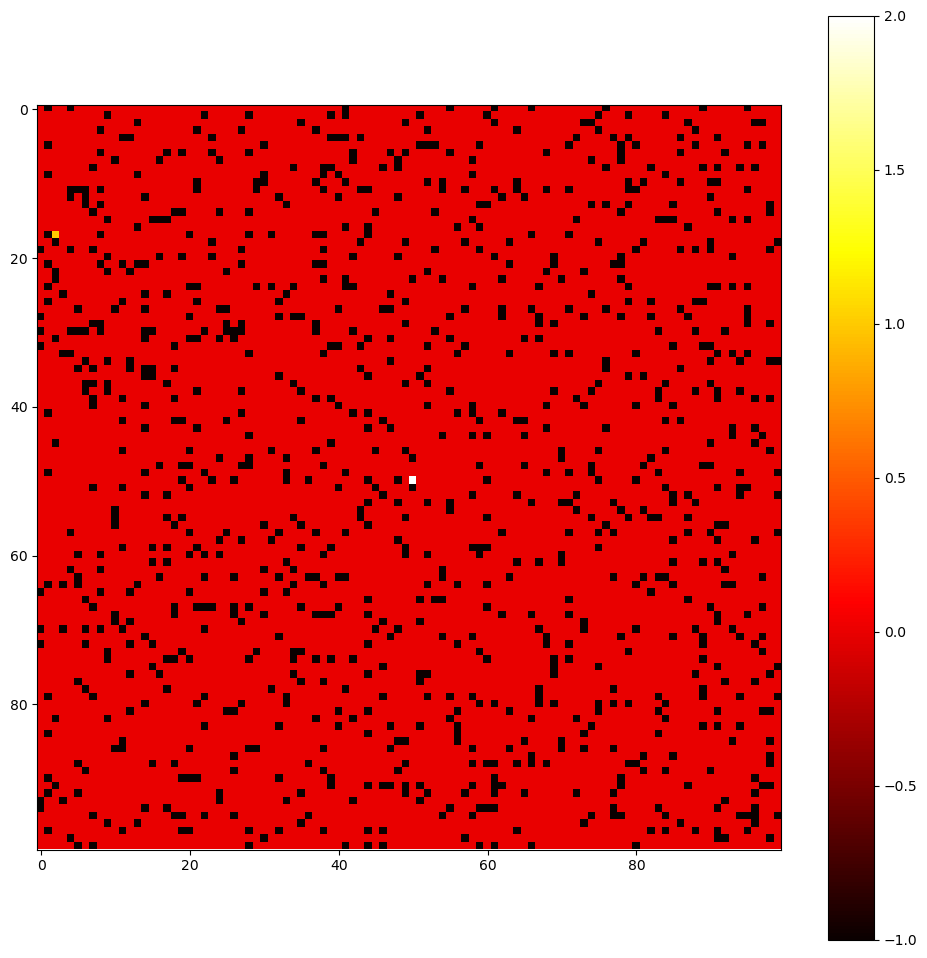

In [51]:
# Visualization after training
state = env.reset()
env.render()
done = False
while not done:
    action = agent.act(state)
    state, _, done = env.step(action)[:3]
    env.render()